# Phase Shift Approach - Velocity Measurements

Castelletti et al. searches for the correct slope of a surface by sweeping ranges/velocities and finding the correct phase correction by maximizing post-summed SNR. Here, we can employ a similar methodology but to find the correct spacecraft velocity.

- Surface echoes from Europa for ranging measurements will arrive later as the spacecraft moves away from the moon. 
- We can sum the received signals, each shifted with a phase correction $\Delta \phi$, to maximize post-summed SNR.
- We sweep ranging measurements to seek the correct velocities. 

This is advantageous because (i) velocity measurements can occur alongside ranging, without previous constraints from Doppler frequency; (ii) aliased results can be eliminated by comparing with Clipper's orbital properties in SPICE; and (iii) uncertainties in range and velocity can be found, across the parameter space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.ticker as mticker
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as path_effects
from scipy.signal import find_peaks
from scipy.ndimage import label, find_objects
import scienceplots
from scipy.optimize import curve_fit 

In [2]:
def scientific_formatter(x, pos):
    # for ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
    if x == 0: return r'$0.0$'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# REASON parameters
Pt_hf = 11.75
Pt_vhf = 5.5
Gt_hf = 10**(4/10) # 4 dB -> B
Gt_vhf = 10**(7.3/10) # 7.3 dB -> B

c = 2.998e8 # m/s
rcs = 2.5e10 # for HF, but we can assume for both

hf_wavelength = c/(9e6) # m
vhf_wavelength = c/(60e6) # m

# Set parameters
hf_pulse_length = 200e-6 # s
hf_repetition_freq = 3000 # Hz
hf_bandwidth = 1e6 # Hz
hf_s = hf_bandwidth/hf_pulse_length # chirp slope, Hz/s
hf_fc = 0 # Hz #9e6 is true value, assume 0 because the hardware downconverts to baseband

vhf_pulse_length = 236e-6 # s
vhf_repetition_freq = 3000 # Hz
vhf_bandwidth = 10e6 # Hz
vhf_s = vhf_bandwidth/vhf_pulse_length # chirp slope, Hz/s
vhf_fc = 60e6 # Hz

# sampling freqs
# 2x complex-valued baseband sampling rate
hf_fs = 2.4e6 
vhf_fs = 24e6

# noise power + effective area
hf_Ae = (Gt_hf*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W
print("Galactic noise (power): {} W".format(N_power))

Galactic noise (power): 2.2180348937986096e-15 W


In [4]:
def radar_equation(Pt, Gt, d, rcs, wavelength):
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    return ((Pt*Gt)/(4*np.pi*d**2))*((rcs*Ae)/(4*np.pi*d**2)) # return power received

In [5]:
def chirp(s, tau, fs, fc, start, n, phase_shift):
    # s: slope
    # tau: pulse length
    # fs: sample rate
    # fc: center frequency
    # start: starting index of chirp
    # n: the length of the chirp including zero

    dt = 1 / fs
    npts = int(tau * fs)
    t = np.arange(-npts/2, npts/2) * dt
    phase = np.pi * s * t**2 + 2 * np.pi * fc * t + phase_shift
    chirp = np.zeros(n, dtype = np.complex_)
    chirp[start:len(phase)+start] = np.exp(1j * phase) # nonzero portion

    return chirp

In [6]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

In [7]:
from tqdm import tqdm

# Modelling ranging measurements for various ranges
def ranging_per_v(start_alt, end_time, vset):
    sampling_rate_m = vset/hf_repetition_freq # in meters
    range_array = np.arange(start_alt, start_alt + end_time*vset, sampling_rate_m)
    
    t = np.arange(0, end_time, 1/hf_fs) # time at the sampling frequency
    output_signal = np.zeros(len(t), dtype=np.complex_) # stores multiple pulses
    
    # ONE CHIRP
    #print(int((1/hf_repetition_freq)*hf_fs)) # 800
    chirpsig = chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), 0)
    
    # iterate through chirps (using pulse_number) until total_pulses
    total_pulses = int(end_time / (1/hf_repetition_freq)) # total number of pulses
    pulse_number = 0
    while pulse_number < total_pulses:
        # if the chirp is cut off at the end of the time period
        if pulse_number * (1/hf_repetition_freq) > end_time:
            continue
        
        # signal spreads out 1/16 pi d^4
        Pr = radar_equation(Pt_hf, Gt_hf, range_array[pulse_number], rcs, hf_wavelength)
        
        start_index = math.ceil(pulse_number * (1/hf_repetition_freq) * hf_fs) # round up to pulse number
        
        # multiply by pulse indices for chirp function above
        output_signal[start_index:start_index+len(chirpsig)] = chirpsig*(np.sqrt(Pr)/np.sqrt(Pt_hf)) 
        #decrease amplitude by ratio of sqrt(power received)/sqrt(power transmitted)
        # in units of AMPLITUDE
        
        pulse_number += 1 # go on to next pulse

    # keep first Pr so that we can convert to power later
    first_Pr = radar_equation(Pt_hf, Gt_hf, range_array[0], rcs, hf_wavelength)
    return output_signal, total_pulses, first_Pr 

## Single pulse SNR
For longest pulse, single pulse SNR with radar equation:

In [8]:
d = 40000*1e3 # m
Pr_hf = radar_equation(Pt_hf, Gt_hf, d, rcs, hf_wavelength)
SNR_singlepulse = 10*np.log10(Pr_hf/N_power)
print("SNR: {:.2f}".format(SNR_singlepulse))

SNR: -37.39


## Pulse Train

Pulse count: 800
Uncompressed P_r/N (power): -232.01 dB


/Users/michpark/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/michpark/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(66666.66666666667, 68333.33333333333)

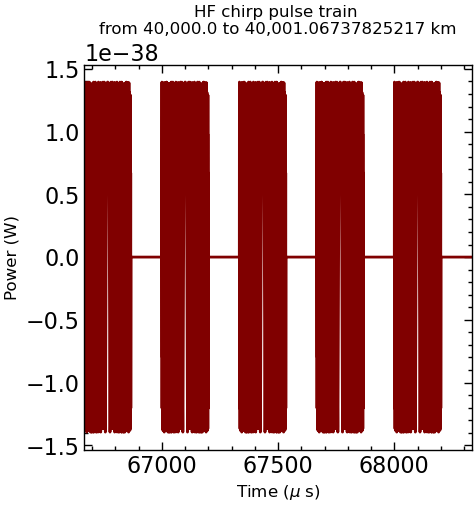

In [9]:
# set up range array
start_alt = d # m
end_time = 2*start_alt/c #s
vtrue = 4e3 #m/s
  
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, vtrue) # assume 4 km/s
noise_power = np.random.normal(loc=N_power, size=len(res)) # in units of amplitude (sqrt(W))

print("Pulse count: {}".format(pulse_count))

print("Uncompressed P_r/N (power): {:.2f} dB".format(10*np.log10(np.max(np.abs(Pr*res**2))/N_power)))

# Times for pulse train
times = np.linspace(0, end_time, len(res)) 
# final time = number of pulses * repetition freq

# Plot figure
plt.style.use(['science', 'notebook'])

fig, ax = plt.subplots(figsize=(5,5))
#plt.plot(times/(1e-6), Pr*res**2 + noise_power, c='gray', label='With noise')
plt.plot(times/(1e-6), Pr*res**2, c='maroon')
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vtrue)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (W)", fontsize = 12)
plt.xlim((200*(1/hf_repetition_freq) / 1e-6, 205*(1/hf_repetition_freq) / 1e-6))

### 3) Pulse compress + estimate the phase correction + SNR
For each surface echoes series, implement pulse compression. Use the maxima of each compressed pulse to estimate the slope of the straight line that travels through, which will be the phase correction. 
Find the final summed, phase-corrected pulse to gather the SNR (power received / noise). 


Hmmm... should i be finding or guessing the phase correction? wouldnt we always be maxing out the snr each time?

In [149]:
# input: res array with pulse train (chirps), estimated phase correction
# output: SNR
def get_SNR(res, noise, pulse_count, vtrue, vtest, dtrue):
    # matched filter is res (no noise), add noise to get the signal
    # matched filter == fft(signal)*fft(filter) conjugate
    if noise != 0: N = np.random.normal(loc=noise, size=len(res)) # create random Gaussian noise
    else: N = np.zeros(len(res), dtype=np.complex_) # else, no noise
    
    # apply matched filter to the noisy signal
    corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(res + N)*np.conj(np.fft.fft(res))))
    
    # find the peaks for each compressed pulse, separated by repetition frequency indexes
    peaks, _ = find_peaks(corr, distance=(1/hf_repetition_freq)*hf_fs)

    final_signal = np.zeros(int((1/hf_repetition_freq)*hf_fs), dtype=np.complex_)
    
    # create array of distance guesses based on pulse size
    time_halfwidth = ((1/hf_repetition_freq))/2
    distance_halfwidth = time_halfwidth*c # corresponds to which "dx" in range guesses
    dguesses = np.linspace(dtrue - distance_halfwidth, dtrue + distance_halfwidth, len(final_signal))
    # ARRAY OF RANGE GUESSES
    
    # FOR GUESSED VELOCITY 
    # Apply phase correction (for each pulse number), from dif between true + guess velocity
    vshift = vtest - vtrue 
    
    # ID the indices labelling the starts + ends of each pulse 
    starts = peaks-int((1/hf_repetition_freq)*hf_fs*0.5)
    ends = peaks+int((1/hf_repetition_freq)*hf_fs*0.5)
    
    phase_corrections = np.array([]) # stores phase corrections for each pulse number
    
    # Create a mask for valid indices -- removes if pulse is truncated
    valid_mask = (starts >= 0) & ((ends - starts) == len(final_signal)) & (ends <= len(corr))
    starts = starts[valid_mask] # apply filter to starts

    # Calculate phase shifts
    multiplier = np.arange(0, len(starts), 1)
    index_per_pulse = int((1/hf_repetition_freq)*hf_fs)

    # determines how many indices we should shift over
    t = (multiplier * (1/hf_fs))/(1/hf_repetition_freq) # fraction of time 
    phaseshift = ((((2*np.pi*np.abs(vshift)*t/hf_wavelength) % (2*np.pi)) / (2*np.pi))) * len(final_signal)
    phase_corrections = phaseshift.astype(int) # convert to ints

    # Extract the pulse data (filtered!)
    #all_indices = np.transpose(np.array([starts, ends]))
    all_pulses = np.array([],dtype=np.complex_)
    all_pulses = np.vstack([corr[start:start + len(final_signal)] for start in starts])

    ## PHASE SHIFTS!!! ##
    for i, shift in enumerate(phase_corrections):
        if vshift < 0: # moving further out from europa
            # pad with zeroes to the LEFT as we shift RIGHT 
            # place to the right
            final_signal[np.abs(shift):] += all_pulses[i][:len(final_signal)-np.abs(shift)]
        else: # moving closer to europa
            # move pulse back, pad with zeroes on right as we shift LEFT
            # place to the LEFT
            final_signal[0:len(all_pulses[i][shift:])] += all_pulses[i][shift:]

    #### PLOT THE PHASE SHIFTED PULSE?
    '''
    pulse_times = np.arange(0, (1/hf_repetition_freq), 1/hf_fs)
    norm = 3.234070710045566e-28
    if vtest == 4e3:
        plt.plot(pulse_times/(1e-6), np.real(final_signal)/norm, label='{:.2f}'.format((vtest-vtrue)), color='black', zorder=1)
    else:
        plt.plot(pulse_times/(1e-6), np.real(final_signal)/norm, label='{:.2f}'.format((vtest-vtrue)), alpha=0.8, zorder=10)
    
    plt.xlabel("Times (microseconds)")
    plt.ylabel("Normalized amplitude")

    #plt.title(r'Final Summed Pulse: $v_{{\rm{{guess}}}}$ = {0} km/s'.format(vtest/1e3), fontsize=12)
    #plt.title(r'Final Summed Pulse - Many Velocity Guesses', fontsize=12)
    plt.legend(title=r'$\Delta v$ (m/s)')
    plt.xlim((145, 190))
    '''
    
    # Instead of sweeping many amplitudes, we can just return the final signal
    # which represents dguess vs. amplitude 
    return dguesses, final_signal

In [140]:
def find_gaussian_fit(x, y):
    # Fit the Gaussian to the data
    # Find the first point after the peak that reaches half the maximum height
    target_index = np.where(y[np.argmax(y):] <= y[np.argmax(y)]/2)[0][0] + np.argmax(y)
    std_lim = x[target_index]-x[np.argmax(y)]
    print(std_lim)

    initial_guess = [np.max(y), np.mean(x), std_lim]

    bounds = ([0, np.min(x), 0], [np.max(y)*2, np.max(x), std_lim])
    
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, maxfev=10000) 
    # extract parameters to describe Gaussian
    
    amplitude, mean, stddev = popt

    # get the gaussian params
    x_fit = np.linspace(np.min(x), np.max(x), 1000)
    y_fit = gaussian(x_fit, *popt)
    
    return x_fit, y_fit, stddev

Now get the SNR for our range guesses, though with a set guessed velocity. Fit with a Gaussian from function above.

Pulse count: 800
0.25014601585268975
Standard deviation: 0.25015


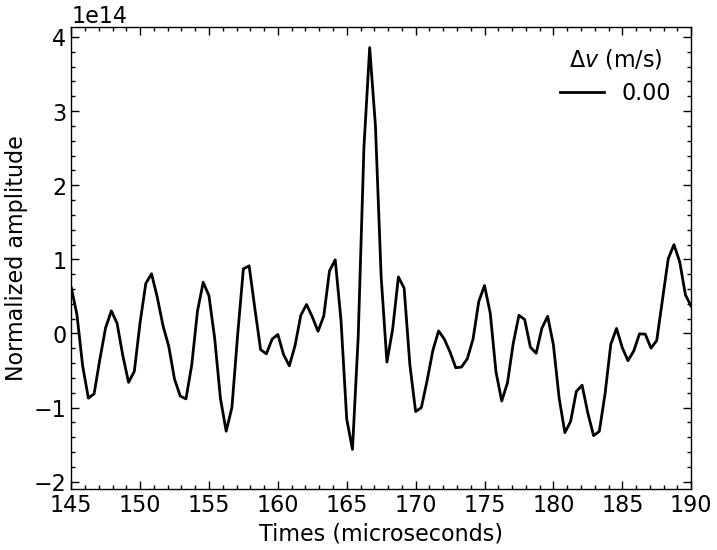

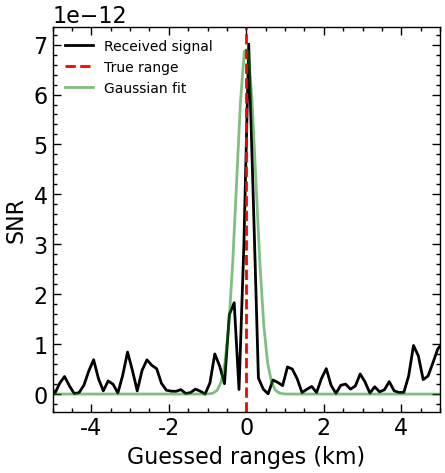

In [141]:
dtrue = 40000e3
vtrue = 4000
vguess = 4e3 # set true guess
end_time = 2*dtrue/c #s

res, pulse_count, Pr = ranging_per_v(start_alt, end_time, vtrue) # assume 4 km/s
print("Pulse count: " + str(pulse_count))

# incoherent summing
'''
n = 1 # number of looks
for iterator in range(n): # for each look
    dguesses, sig_look = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), int(pulse_count/n), vtrue, vguess, dtrue)

    # if first one, define array
    if iterator == 0:
        sig = sig_look
    else:
        sig += np.abs(sig_look)
'''
dguesses, sig = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, vtrue, vguess, dtrue)
# units of Sqrt(W) -- amplitude

'''
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), np.real(res), c='maroon')
plt.scatter(times[peaks]/(1e-6), np.zeros(len(peaks)), zorder=100)
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Amplitude", fontsize = 12)
'''
plt.style.use(['science', 'notebook'])
# plot signal along with range guesses
fig, ax = plt.subplots(figsize=(5,5))
plt.plot((dguesses-dtrue)/1e3, np.abs(sig)**2/N_power, c='black', label='Received signal', alpha=1)
plt.xlabel(r"Guessed ranges (km)")
plt.ylabel("SNR")
#plt.title("Summed time-delayed pulse for {:,} km".format(dtrue/1e3))

# mark the true range
plt.axvline(0, color='red', lw=2, ls='--', label='True range')

# fit with Gaussian
x_fit, y_fit, std = find_gaussian_fit((dguesses-dtrue)/1e3, np.abs(sig)**2/N_power)
print("Standard deviation: {:.5f}".format(std))
plt.plot(x_fit, y_fit, 'g-', alpha=0.5, label='Gaussian fit')

ax.locator_params(axis='x', nbins=5)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlim((-5, 5))
plt.legend(loc='upper left', fontsize = 10)

#### For one range, we get SNR per velocity:

In [127]:
SNR_array = np.array([])
plt.style.use(['science', 'notebook'])
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, 4e3) # assume 4 km/s

vcount = 0
vguesses = np.linspace(4e3-.001e3, 4e3+0.001e3, 100)
for v in vguesses:
    if vcount % 100 == 0: print(vcount)
    
    '''
    # incoherent summing
    n = 100 # number of looks
    for iterator in range(n): # for each look
        _, shifted_look  = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, 4e3, v, 40000e3) 
        
        # if first one, define array
        if iterator == 0:
            shifted_signal = shifted_look
        else:
            shifted_signal += np.abs(shifted_look)
    '''
    _, shifted_signal  = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, 4e3, v, 40000e3) # true alt=40000
    SNR = np.max((np.abs(shifted_signal)**2)/N_power) # in units of power
    SNR_array = np.append(SNR_array, SNR) # not dB
    vcount += 1

0


0.00012121212121246573
Standard deviation: 1.212120e-04


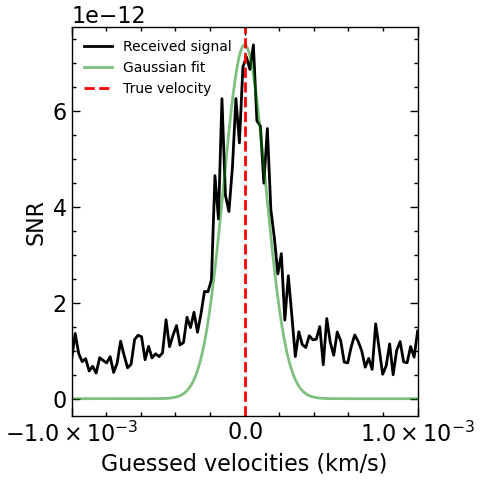

In [129]:
plt.style.use(['science', 'notebook'])
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot((vguesses-vtrue)/1e3, SNR_array, color='black', label='Received signal')

# fit with Gaussian
x_fit, y_fit, std = find_gaussian_fit((vguesses-vtrue)/1e3, SNR_array)
print("Standard deviation: {:e}".format(std))
plt.plot(x_fit, y_fit, 'g-', alpha=0.5, label='Gaussian fit')

plt.xlabel(r"Guessed velocities (km/s)")
plt.ylabel("SNR")

plt.xlim((-0.001, 0.001))

plt.axvline(0, color='red', lw=2, ls='--', label='True velocity')

ax.locator_params(axis='x', nbins=3)
plt.legend(loc='upper left', fontsize = 10)
ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
plt.tight_layout()

### 4) Nested for loop -- many ranges + many velocities
Create a nested for loop implementing each above. Gather the true + recovered ranges, true + recovered velocities (convert phase correction -> velocity), SNR in a 5-value array. 

In [260]:
def guess_both(dtrue, vtrue, vguess_offset, vguess_res, looks):
    velocity_guesses = np.linspace(vtrue-vguess_offset, vtrue+vguess_offset, vguess_res) # m/s
    end_time = 2*dtrue/c  # s

    final = np.zeros((800, len(velocity_guesses))) # 1200 hardcoded ig
    all_SNR = np.zeros((800, len(velocity_guesses))) # 1200 hardcoded ig
    
    res_std = np.zeros(len(velocity_guesses)) # for each v we append

    sampling_rate_m = vtrue/hf_repetition_freq
    
    n = 1 # number of looks
    
    for look in range(1, n+1):
        res, pulse_count, Pr = ranging_per_v(dtrue, end_time/n, vtrue) # with true values
        print("Pulse count: " + str(pulse_count))
    
        for idv, v in enumerate(tqdm(velocity_guesses)):
            #noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
            #N_jupiter_power = 10**-14 * (hf_bandwidth/1e6) * hf_Ae # W
            N_power = N_galactic* (hf_bandwidth/1e6) * hf_Ae 
            
            # add to fraction of SNR
            distance_guesses, snr_look = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, vtrue, v, dtrue)
            all_SNR[:,idv] = snr_look # populate all_SNR array for that look
        
        if look == 1: final = all_SNR # append to final array # don't abs val
        else: final += np.abs(all_SNR)
            
    final = 10*np.log10((np.abs(final)**2)/N_power + (10**-100)) # convert to db in last step
            
    return final, distance_guesses, velocity_guesses

In [261]:
dtrue = 100000e3 # m
vtrue = 4e3 
vguess_offset = 0.0005e3
vguess_res = 200 # how much velocity resolution for guesses

final, distance_guesses, velocity_guesses = guess_both(dtrue, vtrue, vguess_offset, vguess_res, 1)
# dtrue = 400000e3, vtrue = 100000e3 
#np.savetxt("final/final_400000km.txt", final)

print(final)

Pulse count: 2001


  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/6n/3jk8q74x38948bsdc0l81_040000gn/T/ipykernel_13542/4077642461.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  all_SNR[:,idv] = snr_look # populate all_SNR array for that look
100%|█████████████████████████████████████████| 200/200 [01:55<00:00,  1.74it/s]

[[-176.42678979 -167.7988138  -177.68137386 ... -158.80979174
  -153.76579808 -158.68104904]
 [-188.57456268 -161.66296319 -179.19024296 ... -154.52742215
  -150.64688025 -162.42134167]
 [-197.30216373 -157.92084997 -177.12138038 ... -166.14846402
  -149.44903092 -161.95523517]
 ...
 [-150.97506741 -177.64732854 -168.85027106 ... -171.68172939
  -156.84496345 -180.42270159]
 [-154.35331533 -157.95452176 -165.48867147 ... -196.96856244
  -160.90115017 -169.2654439 ]
 [-162.26577748 -150.50324691 -156.38793155 ... -181.9124615
  -176.94599018 -167.0469685 ]]


Determine the rectangle that fits the top 0.1% of SNR and the resolution/accuracy of range/velocity:

In [273]:
def get_resolution(final, distance_guesses, velocity_guesses):
    # We can assume that the brightest point is our recovered answer
    max_index = np.unravel_index(np.argmax(final), final.shape)
    # max_index[0] stores best range, max_index[1] stores best velocity
    
    # For the answer's range, what is velocity Gaussian? (horizontal slice)
    _, _, std_vel = find_gaussian_fit(velocity_guesses, 10**(final[max_index[0]]/10))
    
    # For the answer's velocity, what is range Gaussian? (vertical slice)
    x_fit, y_fit, std_range = find_gaussian_fit(distance_guesses/1e3, 10**(final[:,max_index[1]]/10))
    
    '''
    # plot slice
    plt.figure()
    plt.plot(distance_guesses/1e3, 10**(final[:,max_index[1]]/10))
    plt.plot(x_fit, y_fit)
    plt.xlabel("Distance guesses (km)")
    plt.ylabel("SNR")
    #plt.xlim((40000-5, 40000+5))
    plt.figure()
    '''
    
    return std_range, std_vel # in km, m/s

def get_rectangle(dtrue, vtrue, std_range, std_vel):
    # FROM STD
    # Get the coordinates for the rectangle
    y_start, y_stop = (-std_range, std_range)
    x_start, x_stop = (-std_vel, std_vel)

    return [x_start, x_stop, y_start, y_stop]
    

In [236]:
# DEBUG for resolution
std_range, std_vel = get_resolution(final, distance_guesses, velocity_guesses)
print("Range resolution: {:e} km".format(std_range))
print("Velocity resolution: {:e} m/s".format(std_vel))

0.04522613065319092
0.25014601585280616
Range resolution: 2.501460e-01 km
Velocity resolution: 4.522613e-02 m/s


In [245]:
## VEL RES VS. LOOKS
velres_array = []
dtrue = 40000e3 # m
vtrue = 4e3 
vguess_offset = 0.0005e3
vguess_res = 200 # how much velocity resolution for guesses

for look_count in range(1, 5):
    if look_count % 5 == 0: print(look_count)
    final, distance_guesses, velocity_guesses = guess_both(dtrue, vtrue, vguess_offset, vguess_res, look_count)
    _, std_vel = get_resolution(final, distance_guesses, velocity_guesses)
    velres_array.append(std_vel)

Pulse count: 800


  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/6n/3jk8q74x38948bsdc0l81_040000gn/T/ipykernel_13542/3834841780.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  all_SNR[:,idv] = snr_look # populate all_SNR array for that look
100%|█████████████████████████████████████████| 200/200 [06:23<00:00,  1.92s/it]


0.07537688442243962
0.25014601585280616
Pulse count: 800


100%|█████████████████████████████████████████| 200/200 [27:56<00:00,  8.38s/it]


0.005025125627980742
0.25014601585280616
Pulse count: 800


100%|█████████████████████████████████████████| 200/200 [09:23<00:00,  2.82s/it]


0.09547738693481733
0.25014601585280616
Pulse count: 800


100%|█████████████████████████████████████████| 200/200 [12:32<00:00,  3.76s/it]

0.015075376884396974
0.25014601585280616


[0.025125628040358457, 0.03517587929677469, 0.07035175869400413, 0.030150753668793946, 0.010050251156416232, 0.06532663306556864, 0.06532663306602339, 0.00502512552843549, 0.14070351748800825, 0.020100502412832462, 0.05527638180960715, 0.04522613055319092, 0.0050251255279807425, 0.060301507437587894, 0.07537688432198487, 0.07537688432243962, 0.0050251255279807425, 0.06532663306556864, 0.06532663306556864]


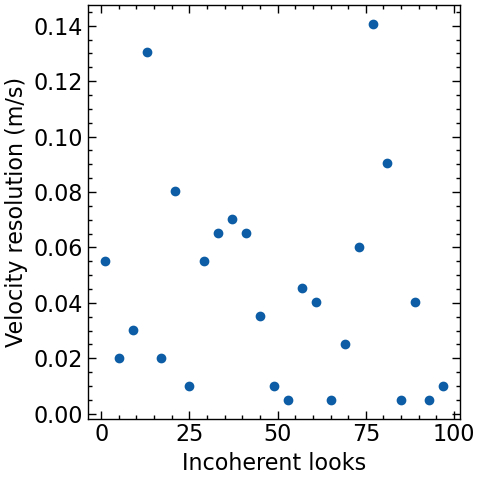

In [244]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(range(1,100)[::4], velres_array[::4])

plt.xlabel(r"Incoherent looks")
plt.ylabel("Velocity resolution (m/s)")

print(res_array)

#ax.locator_params(axis='x', nbins=3)
#ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
plt.tight_layout()

Plot results (heatmap).

Recovered range: 100000.062537 km
Recovered velocity: 4.000018 km/s
--------------
0.015075376884396974
0.12507300791912712
Range resolution: 1.250730e-01 km
Velocity resolution: 1.507538e-02 m/s
[-0.015075376784396974, 0.015075376784396974, -0.1250730078191271, 0.1250730078191271]


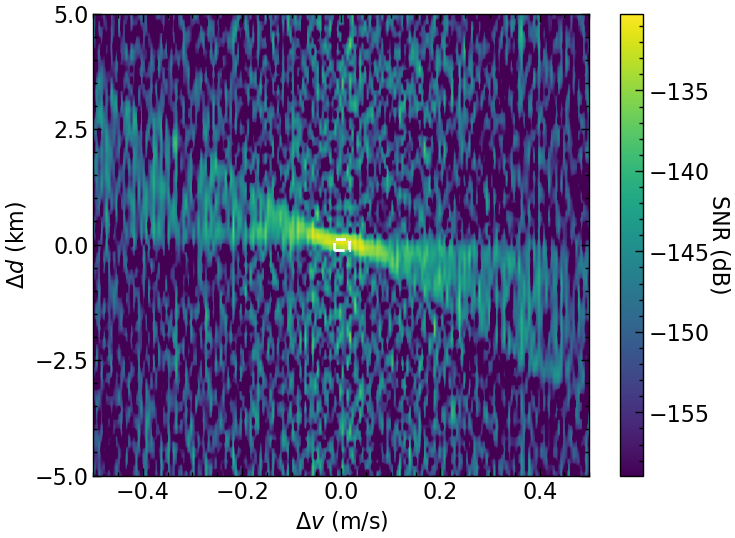

In [274]:
#plt.style.use('/Users/michpark/Sync/Documents/JPL-EUROPA/sample.mplstyle')
plt.style.use(['science', 'notebook'])

# create the colorplot
fig, ax = plt.subplots(figsize=(8, 6))
vmin_val = (np.max(final)-np.min(final)) / 1.3 + np.min(final)

heatmap = ax.imshow(final, cmap='viridis', origin="lower",aspect='auto', vmin = vmin_val, 
              vmax = np.max(final), extent =[(np.min(velocity_guesses)-vtrue), 
                                     (np.max(velocity_guesses)-vtrue), (np.min(distance_guesses)-dtrue)/1e3, 
                                     (np.max(distance_guesses)-dtrue)/1e3])


# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('SNR (dB)', rotation=270, labelpad=15)

# Create a ScalarFormatter with no decimal places
from matplotlib.ticker import ScalarFormatter
c_format = ScalarFormatter(useOffset=False)
c_format.set_scientific(False)
c_format.set_powerlimits((-1,1))
cbar.ax.yaxis.set_major_formatter(c_format)

# Customize the plot
ax.set_ylabel(r'$\Delta d$ (km)')
ax.set_xlabel(r'$\Delta v$ (m/s)')
#ax.set_title('Phase Shift Approach: {} pulses'.format(pulse_count, dtrue))

recovered_indices = np.unravel_index(final.argmax(), final.shape)
print("Recovered range: {:.6f} km".format(distance_guesses[recovered_indices[0]]/1e3))
print("Recovered velocity: {:.6f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))
print("--------------")

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Display resolution params
range_res, vel_res = get_resolution(final, distance_guesses, velocity_guesses)
print("Range resolution: {:e} km".format(range_res))
print("Velocity resolution: {:e} m/s".format(vel_res))

# Obtain SNR rectangle parameters
[x_start, x_stop, y_start, y_stop] = get_rectangle(dtrue, vtrue, range_res, vel_res)
x
# Draw the rectangle
rect = plt.Rectangle((x_start, y_start), x_stop-x_start, y_stop-y_start, 
                     edgecolor='white', facecolor='none', linewidth=2, ls='--', path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
ax.add_patch(rect)

# annotate with the width + height of box
#ax.annotate('{:.3f} cm/s'.format(vel_res), (x_start + (x_stop-x_start)/2, y_start-(y_stop-y_start)/2.9), ha='center', color='white', fontsize=14, fontweight='bold')
#ax.annotate('{:.3f} km'.format(range_res), (x_start - (x_stop-x_start)/1.3, y_start + (y_stop-y_start)/2), va='center', color='white', fontsize=14, fontweight='bold')

# annotate with recovered values
#ax.text(x=0.05, y=0.93, s=r'Range offset: {:.4f} km'.format(np.mean([y_start, y_stop])/1e3), transform=ax.transAxes, color='white')
#ax.text(x=0.05, y=0.89, s=r'Velocity offset: {:.4f} m/s'.format(np.mean([x_start, x_stop])), transform=ax.transAxes, color='white')

plt.ylim((x_start/1e3-5, x_stop/1e3+5))

plt.show()

## Range/velocity resolution vs. range!
To explore how resolution changes as we go further and closer to Europa -- might be good to include in the paper to demonstrate tradeoff.

In [ ]:
true_range = np.linspace(40000e3, 100000e3, 10) # from 40,000 km to 100,000 km

res_array = np.zeros(2) # collect resolutions

# as Europa Clipper moves further away...
for dtrue in true_range:
    print("TRUE RANGE: {} km".format(dtrue/1000))
    # Run colormap determination
    final, distance_guesses, velocity_guesses = guess_both(dtrue, 4000, 0.0005e3, 50)
    
    # get resolution 
    range_res, vel_res = get_resolution(final, distance_guesses, velocity_guesses)
    res_array = np.vstack((res_array, [range_res, vel_res]))

res_array = res_array[1:] # remove first row of zeroes

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

# PLOT RESOLUTION RESULTS
ax[0].plot(true_range, res_array[:,0], c='navy')
ax[1].plot(true_range, res_array[:,1], c='maroon')

# PRETTIFY THE AXES
ax[0].set_ylabel("Range resolution (km)")
ax[1].set_ylabel("Velocity resolution (m/s)")

for axes in ax.reshape(-1):
    axes.locator_params(axis='x', nbins=7)
    axes.locator_params(axis='y', nbins=5)
    axes.set_xlabel("True range (km)")
    
plt.tight_layout()

## Side-by-side pulse count comparison
Compare 400 vs. 800 pulses, for paper.

In [ ]:
all_final = [final_part, final_full]
plt.style.use(['science', 'notebook'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for j in range(2):
    ax = axs[j]
    final = all_final[j]
    vmin_val = (np.max(final)-np.min(final)) / 1.2 + np.min(final)
    heatmap = ax.imshow(final, cmap='viridis', origin="lower",aspect='auto', vmin = vmin_val, 
              vmax = np.max(final), extent =[(np.min(velocity_guesses)-vtrue), 
                                     (np.max(velocity_guesses)-vtrue), (np.min(distance_guesses)-dtrue)/1e3, 
                                     (np.max(distance_guesses)-dtrue)/1e3])

    # Customize the plot
    ax.set_ylabel(r'$\Delta d$ (km)')
    ax.set_xlabel(r'$\Delta v$ (m/s)')
    
    ax.locator_params(axis='x', nbins=5)
    recovered_indices = np.unravel_index(final.argmax(), final.shape)
    
    # Draw the rectangle
    [x_start, x_stop, y_start, y_stop] = get_rectangle(final, distance_guesses, velocity_guesses)
    rect = plt.Rectangle((x_start - 0.5*np.diff(velocity_guesses)[0], y_start - 0.5*np.diff(distance_guesses)[0]/1e3), x_stop - x_start, y_stop - y_start, 
                         edgecolor='white', facecolor='none', linewidth=2, ls='--', path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
    ax.add_patch(rect)
    ax.set_xlim((-0.5, 0.5))
    ax.set_ylim((-1, 1))

axs[0].set_title("400 pulses")
axs[1].set_title("800 pulses")
plt.tight_layout()
# Add colorbar
bottom, top = 0.1, 0.9
left, right = 0.1, 0.8
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.1, wspace=0.25)
cbar_ax = fig.add_axes([0.83, bottom, 0.02, top-bottom])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
cbar.set_label('SNR (dB)', rotation=270, labelpad=20)

#ax.text(x=0.05, y=0.93, s=r'Recovered range: {:.6f} km'.format(distance_guesses[recovered_indices[0]]/1e3), transform=ax.transAxes, color='white')
#ax.text(x=0.05, y=0.89, s=r'Recovered velocity: {:.6f} km/s'.format(velocity_guesses[recovered_indices[1]]/1e3), transform=ax.transAxes, color='white')
plt.show()

### 5) Monte Carlo type plot 
(1) Find the brightest SNR point on heatmap -> (2) Rerun new heatmap and get its brightest SNR point -> (3) repeat.
We can see how the brightest SNR point deviates for multiple runs of the heatmap (standard deviation of the movement) to see extent of noise's influence

In [ ]:
# set up params
dtrue = 1000000e3
vtrue = 4000 # m/s -- the actual velocity

hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W

n_iterations = 101

pbar = tqdm(total=n_iterations)

all_ranges = np.zeros(n_iterations)
all_velocities = np.zeros(n_iterations)

n = 1
velocity_guesses = np.linspace(vtrue-0.0005e3, vtrue+0.0005e3, 50) # m/s
end_time = 2*dtrue/c # s

res, pulse_count, Pr = ranging_per_v(dtrue, end_time, vtrue) # with true values

while n <= n_iterations:
    # Preallocate results
    max_SNR = -np.inf  # Initialize maximum SNR to a very low value
    best_range = None
    best_velocity = None

    for idv, v in enumerate(velocity_guesses):
        distance_guesses, snr_guesses = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, vtrue, v, dtrue)
        SNR = 10*np.log10((np.abs(snr_guesses)**2)/N_power + (10**-100))
        
        current_SNR = np.max(SNR) # find the maximum among the distance guesses

        if current_SNR > max_SNR:
            max_SNR = current_SNR
            best_range = distance_guesses[np.argmax(SNR)] / 1e3  # Store the best range in km
            best_velocity = velocity_guesses[idv]  # Store the best velocity in m/s

    all_ranges[n-1] = best_range
    all_velocities[n-1] = best_velocity
    
    # iterate and update progress bar
    n += 1
    pbar.update(1)
    
pbar.close()

In [ ]:
np.savetxt("iterative_heatmaps/allranges-millionkm.txt", all_ranges)
np.savetxt("iterative_heatmaps/allvelocities-millionkm.txt", all_velocities)

In [ ]:
import math
import scipy.stats as stats

#all_ranges = np.loadtxt("iterative_heatmaps/allranges-full.txt")
#all_velocities = np.loadtxt("iterative_heatmaps/allvelocities-full.txt")

n = len(all_ranges)
print(pulse_count)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
N_bins = math.ceil(np.sqrt(n)) # general policy -- number of bins = round up sqrt(number of data)

# BUILD THE HISTOGRAMS
binsd = np.linspace(-1, 1, int(N_bins/1.5))
binsv = np.linspace(-0.5, 0.5, int(N_bins))
_, xrange, _ = ax[0].hist(all_ranges-dtrue/1e3, color='#107394', bins=binsd, edgecolor='black', linewidth=1.2)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
_, xvel, _ = ax[1].hist(all_velocities-vtrue, color='#7b0829', bins=binsv, edgecolor='black', linewidth=1.2)
ax[1].axvline(vtrue, ls='--', color='black')

# PRETTIFY THE AXES
ax[0].set_xlabel(r'$\Delta d$ (km)')
ax[1].set_xlabel(r'$\Delta v$ (m/s)')
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)
ax[0].locator_params(axis='x', nbins=5)
ax[1].locator_params(axis='x', nbins=5)

# CALCULATE BIAS AND SCATTER
range_bias = np.median(all_ranges - np.full(len(all_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(all_ranges - np.full(len(all_ranges), dtrue/1e3)))
velocity_bias = np.median(all_velocities - np.full(len(all_velocities), vtrue))
velocity_scatter = np.std(np.abs(all_velocities - np.full(len(all_velocities), vtrue)))                    
                       
ax[0].text(x=0.05, y=0.91, s=r'$\mu$ = {:.3f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394', fontsize=13)
ax[0].text(x=0.05, y=0.85, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394', fontsize=13)
ax[1].text(x=0.53, y=0.91, s=r'$\mu$ = {:.2e} m/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829', fontsize=13)
ax[1].text(x=0.53, y=0.85, s=r'$\sigma$ = {:.2e}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829', fontsize=13)
         
for axes in ax.reshape(-1):
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].set_ylim(top=400)

fig.suptitle("800 pulses", fontsize=16)
plt.tight_layout()